In [1]:
##### Import packages
# Basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling packages
from sklearn.impute import SimpleImputer
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Other packages
from datetime import datetime
from collections import Counter

# To avoid warnings
import warnings
warnings.filterwarnings("ignore")

# The objective of creating a prediction model based on Machine Learning Algorithms is to __check the probability of dying if you are COVID-19 confirmed__

In [2]:
##### Import data
# Check the csv's path before running it

df_est = pd.read_csv("CoordEstados.csv", encoding = "ISO-8859-1") # Mexican states data
df_cov = pd.read_csv("14.11.20 - COVID19MEXICO.csv", encoding = "ISO-8859-1") # Covid-19 data

# Data Preparation

In [3]:
##### Create a new column with the time difference between been positive in COVID-19 and die
# If the person didn't die, time difference is 0

df_cov['FECHA_SINTOMAS'] = df_cov['FECHA_SINTOMAS'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
df_cov['FECHA_DEF'] = df_cov['FECHA_DEF'].replace('9999-99-99', '2001-01-01')

df_cov['FECHA_DEF'] = df_cov['FECHA_DEF'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
df_cov['DIFERENCIA'] = df_cov['FECHA_DEF'].sub(df_cov['FECHA_SINTOMAS'], axis=0)

df_cov['DIFERENCIA'] = df_cov['DIFERENCIA'] / np.timedelta64(1, 'D')
df_cov.loc[df_cov['DIFERENCIA']<0,'DIFERENCIA'] = 0

In [4]:
##### Create a new column with boolean value: 0 if the person doesn't have any disease, ≠ 0 otherwise
# Change the classification method from 1 yes 2 no to 1 yes 0 no. In this case, unknown values will be considered as no.

ill_name = ['DIABETES','EPOC','ASMA','INMUSUPR','HIPERTENSION','OTRA_COM','CARDIOVASCULAR','OBESIDAD','RENAL_CRONICA']
df_cov[ill_name] = df_cov[ill_name].replace([2,98],0)

df_cov['n_ENFERMEDADES'] = df_cov[ill_name].sum(axis = 1)

In [5]:
##### Create a new column (target) with boolean value: 0 if the person doesn't die, 1 otherwise

df_cov.loc[df_cov['DIFERENCIA']==0,'MORTALIDAD'] = 0
df_cov.loc[df_cov['DIFERENCIA']!=0,'MORTALIDAD'] = 1

In [6]:
##### Replacing missing values with NaNs

df_cov.replace([97,98,99],np.nan,inplace=True)
df_cov.isnull().sum()/len(df_cov)*100

FECHA_ACTUALIZACION     0.000000
ID_REGISTRO             0.000000
ORIGEN                  0.000000
SECTOR                  0.000384
ENTIDAD_UM              0.000000
SEXO                    0.000000
ENTIDAD_NAC             0.481791
ENTIDAD_RES             0.000000
MUNICIPIO_RES           0.725200
TIPO_PACIENTE           0.000000
FECHA_INGRESO           0.000000
FECHA_SINTOMAS          0.000000
FECHA_DEF               0.000000
INTUBADO               85.005139
NEUMONIA                0.702933
EDAD                    0.028411
NACIONALIDAD            0.000000
EMBARAZO               48.965335
HABLA_LENGUA_INDIG      3.813244
INDIGENA                3.695570
DIABETES                0.000000
EPOC                    0.000000
ASMA                    0.000000
INMUSUPR                0.000000
HIPERTENSION            0.000000
OTRA_COM                0.000000
CARDIOVASCULAR          0.000000
OBESIDAD                0.000000
RENAL_CRONICA           0.000000
TABAQUISMO              0.319351
OTRO_CASO 

In [7]:
##### Deleting columns with NaNs > 0.8

df_cov.drop(columns=['INTUBADO', 'MIGRANTE', 'UCI'], inplace = True)

In [8]:
##### Using SimpleImputer for missing values

imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df_cov_imputer = imputer.fit_transform(df_cov)

df_cov = pd.DataFrame(df_cov_imputer, columns = df_cov.columns)
df_cov.isnull().sum()/len(df_cov)*100

FECHA_ACTUALIZACION    0.0
ID_REGISTRO            0.0
ORIGEN                 0.0
SECTOR                 0.0
ENTIDAD_UM             0.0
SEXO                   0.0
ENTIDAD_NAC            0.0
ENTIDAD_RES            0.0
MUNICIPIO_RES          0.0
TIPO_PACIENTE          0.0
FECHA_INGRESO          0.0
FECHA_SINTOMAS         0.0
FECHA_DEF              0.0
NEUMONIA               0.0
EDAD                   0.0
NACIONALIDAD           0.0
EMBARAZO               0.0
HABLA_LENGUA_INDIG     0.0
INDIGENA               0.0
DIABETES               0.0
EPOC                   0.0
ASMA                   0.0
INMUSUPR               0.0
HIPERTENSION           0.0
OTRA_COM               0.0
CARDIOVASCULAR         0.0
OBESIDAD               0.0
RENAL_CRONICA          0.0
TABAQUISMO             0.0
OTRO_CASO              0.0
TOMA_MUESTRA           0.0
RESULTADO_LAB          0.0
CLASIFICACION_FINAL    0.0
PAIS_NACIONALIDAD      0.0
PAIS_ORIGEN            0.0
DIFERENCIA             0.0
n_ENFERMEDADES         0.0
M

In [9]:
##### Selecting all the columns to use to modelling (also the target)

features = list(df_cov)
remove = ['FECHA_ACTUALIZACION', 'ID_REGISTRO', 'FECHA_INGRESO','FECHA_SINTOMAS','FECHA_DEF','HABLA_LENGUA_INDIG','CLASIFICACION_FINAL',
          'PAIS_NACIONALIDAD','RESULTADO_LAB','PAIS_ORIGEN','NACIONALIDAD','EMBARAZO','DIFERENCIA','MORTALIDAD']

for col in remove:
    features.remove(col)

# Modelling

In [10]:
##### Creation of x and y

X = df_cov[features].values.astype('int')
y = df_cov['MORTALIDAD'].values.astype('int')

In [11]:
##### Creation of X and y split -- train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y)

## Random Forest

In [12]:
##### Random Forest

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

yhat = clf.predict(X_test)
print('Accuracy score: ',accuracy_score(y_test,yhat))

Accuracy score:  0.9496632957852464


In [13]:
##### Classification Report

print(classification_report(y_test, yhat, digits=3))

              precision    recall  f1-score   support

           0      0.966     0.982     0.974    986834
           1      0.534     0.372     0.438     55030

    accuracy                          0.950   1041864
   macro avg      0.750     0.677     0.706   1041864
weighted avg      0.943     0.950     0.945   1041864



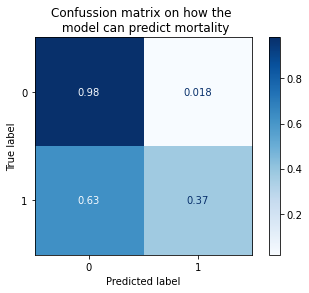

In [14]:
##### Confussion Matrix

plot_confusion_matrix(clf, X_test, y_test,
                             display_labels=[0,1],
                             cmap=plt.cm.Blues,
                             normalize="true")
plt.title('Confussion matrix on how the \n model can predict mortality')
plt.show()

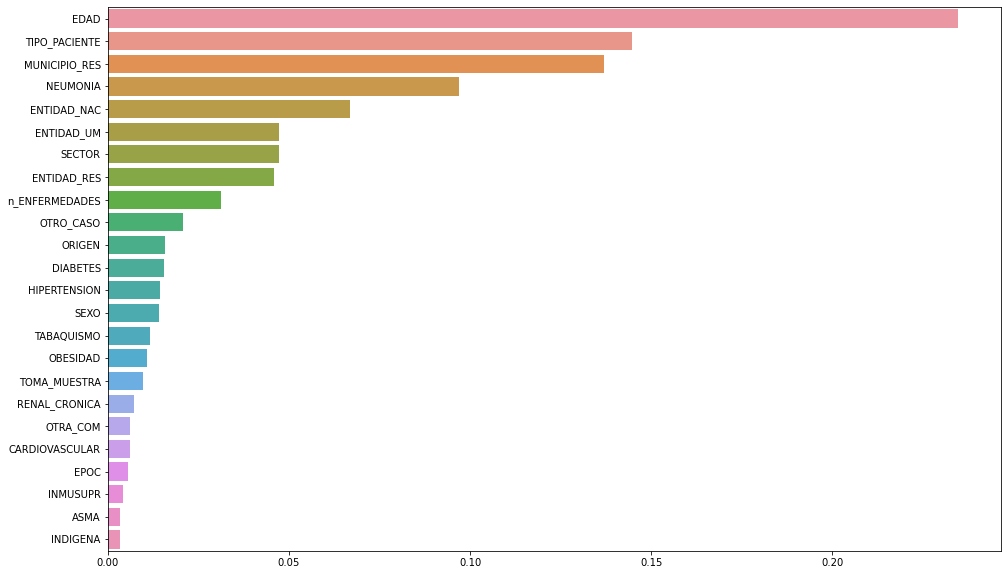

In [15]:
##### Feature Importance

features_importance = clf.feature_importances_
features_array = np.array(features)
features_array_ordered = features_array[(features_importance).argsort()[::-1]]
features_array_ordered

plt.figure(figsize=(16,10))
sns.barplot(y = features_array, x = features_importance, orient='h', order=features_array_ordered[:50])

plt.show()

## Logistic Regression

In [16]:
##### Logistic Regression

clf = LogisticRegression(solver='liblinear')
clf.fit(X_train, y_train)

yhat = clf.predict(X_test)
print('Accuracy score: ',accuracy_score(y_test,yhat))

Accuracy score:  0.9501662405073983


In [17]:
##### Classification Report

print(classification_report(y_test, yhat, digits=3))

              precision    recall  f1-score   support

           0      0.963     0.985     0.974    986834
           1      0.548     0.321     0.405     55030

    accuracy                          0.950   1041864
   macro avg      0.756     0.653     0.690   1041864
weighted avg      0.941     0.950     0.944   1041864



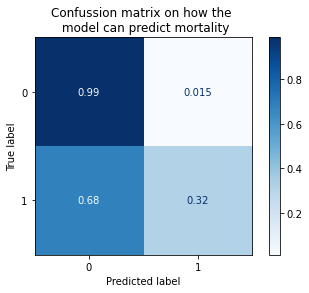

In [18]:
##### Confussion Matrix

plot_confusion_matrix(clf, X_test, y_test,
                             display_labels=[0,1],
                             cmap=plt.cm.Blues,
                             normalize="true")
plt.title('Confussion matrix on how the \n model can predict mortality')
plt.show()

## UnderSampling

In [19]:
##### Undersampling to create sintetic data to improve class balance.
# Increase minority class size until its size represent 80% of major class size

undersampling = RandomUnderSampler(sampling_strategy=0.8) 
X_balance, y_balance = undersampling.fit_resample(X, y)
Counter(y_balance)

Counter({0: 171967, 1: 137574})

In [20]:
##### Creation of X and y split -- train and test applying undersampling

X_train, X_test, y_train, y_test = train_test_split(X_balance, y_balance, test_size=0.4)

## Random Forest with UnderSampling

In [21]:
##### Random Forest with UnderSampling

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

yhat = clf.predict(X_test)
print('Accuracy score: ',accuracy_score(y_test,yhat))

Accuracy score:  0.9144059377952947


In [22]:
##### Classification Report

print(classification_report(y_test, yhat, digits=3))

              precision    recall  f1-score   support

           0      0.949     0.895     0.921     69075
           1      0.876     0.939     0.907     54742

    accuracy                          0.914    123817
   macro avg      0.913     0.917     0.914    123817
weighted avg      0.917     0.914     0.915    123817



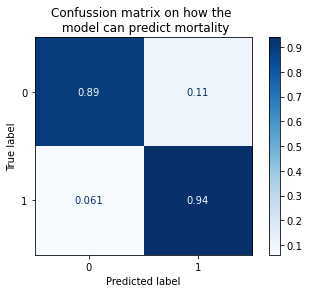

In [23]:
##### Confussion Matrix

plot_confusion_matrix(clf, X_test, y_test,
                             display_labels=[0,1],
                             cmap=plt.cm.Blues,
                             normalize="true")
plt.title('Confussion matrix on how the \n model can predict mortality')
plt.show()

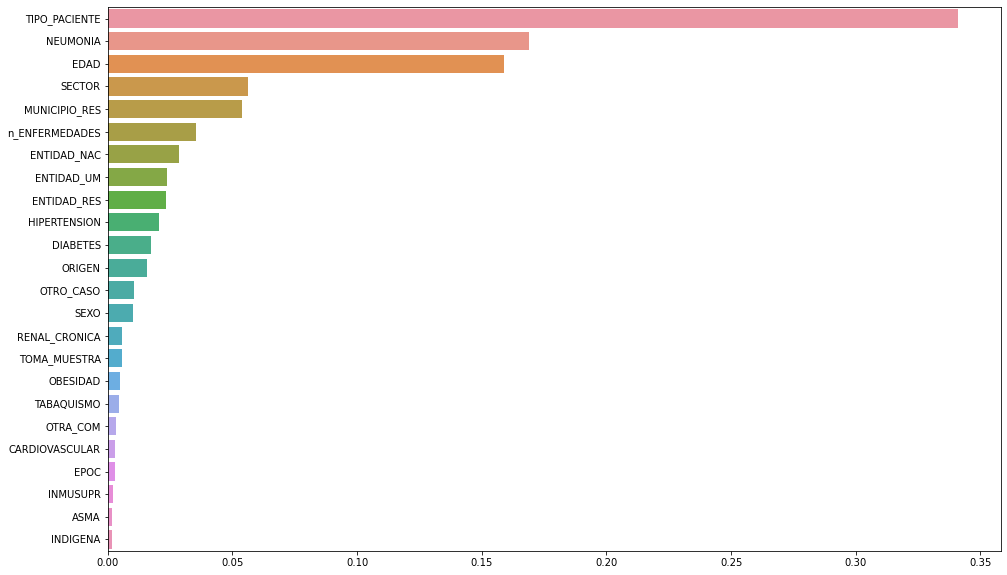

In [24]:
##### Feature Importance

features_importance = clf.feature_importances_
features_array = np.array(features)
features_array_ordered = features_array[(features_importance).argsort()[::-1]]
features_array_ordered

plt.figure(figsize=(16,10))
sns.barplot(y = features_array, x = features_importance, orient='h', order=features_array_ordered[:50])

plt.show()

## Logistic Regression with UnderSampling

In [25]:
##### Logistic Regression with UnderSampling

clf = LogisticRegression(solver='liblinear')
clf.fit(X_train, y_train)

yhat = clf.predict(X_test)
print('Accuracy score: ',accuracy_score(y_test,yhat))

Accuracy score:  0.9076621142492549


In [26]:
##### Classification Report

print(classification_report(y_test, yhat, digits=3))

              precision    recall  f1-score   support

           0      0.926     0.907     0.916     69075
           1      0.885     0.909     0.897     54742

    accuracy                          0.908    123817
   macro avg      0.906     0.908     0.907    123817
weighted avg      0.908     0.908     0.908    123817



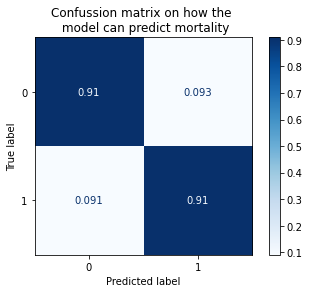

In [27]:
##### Confussion Matrix

plot_confusion_matrix(clf, X_test, y_test,
                             display_labels=[0,1],
                             cmap=plt.cm.Blues,
                             normalize="true")
plt.title('Confussion matrix on how the \n model can predict mortality')
plt.show()